In [63]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [68]:
cleansed=load_amihud_markets_price()

In [70]:
cleansed.count().count()

123

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [71]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

Idea:

* Sort portfolios on an annual baisis
* cacluated $\sigma$, $\mu$, skew, max drawdown

In [72]:
number_of_buckets=10
stdev=[]
rtns=[]
mu=[]
for y in range(2000,2016,1):
    year=str(y) + '-12-31'
    s=[]
    s.append(y)
    mu.append(y)
    for i in range(0,number_of_buckets,1):
        mkts=quantile_columns(amihud.resample(rule='a',how='median'),year,number_of_buckets,i)
        mu.append(cleansed.resample(rule='a',how='last')[mkts].pct_change()[str(y+1)].median().median()) 
        s.append(cleansed.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].std().median()) 
    stdev.append(s)
    rtns.append(mu)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


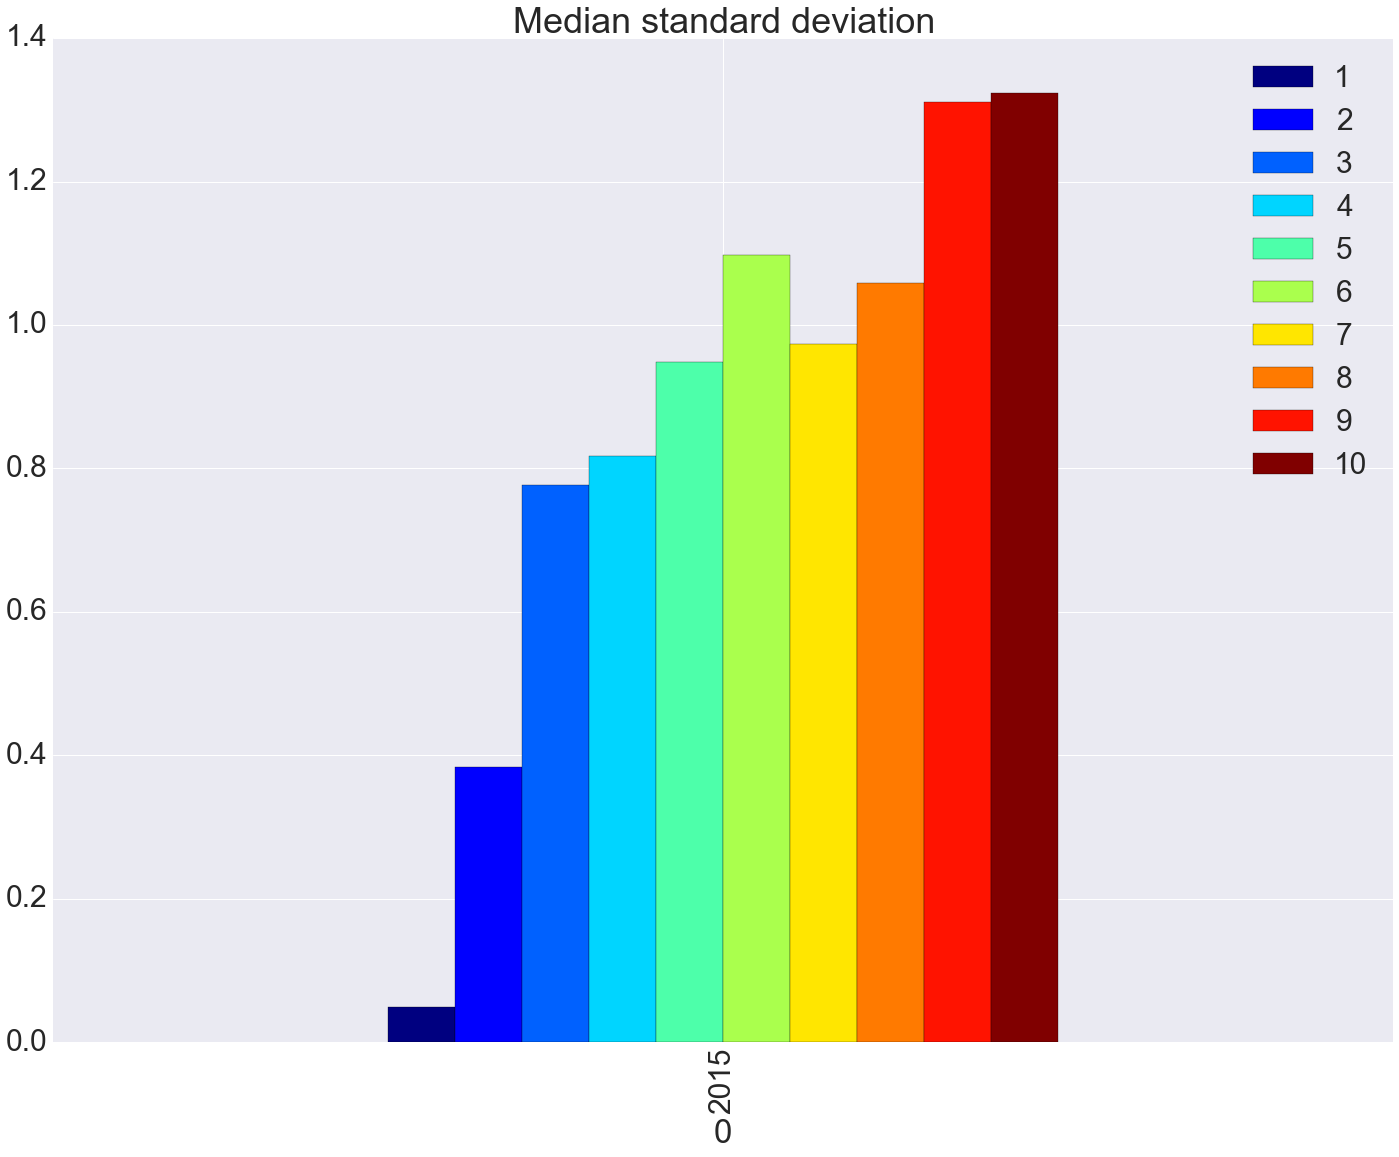

In [73]:
pd.DataFrame(stdev).set_index(0).cumsum().tail(1).plot(colormap='jet',kind='bar',title='Median standard deviation')

* Need to creat panel data and start running regression on that.  

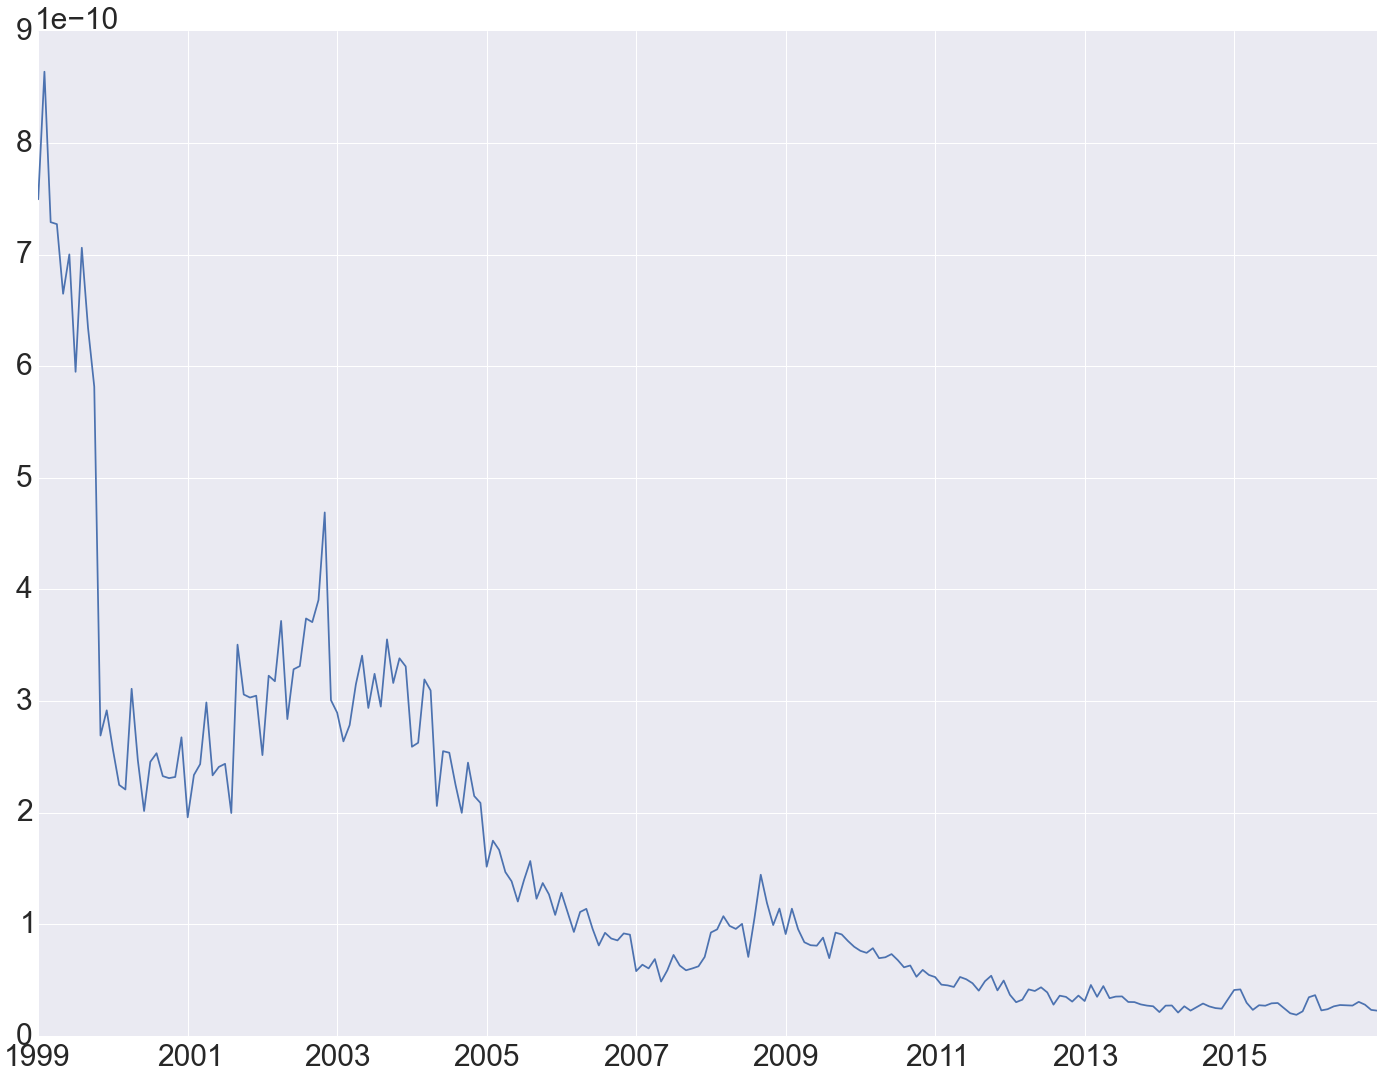

In [74]:
amihud.median(axis=1).dropna().plot()

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


In [157]:
un_dec=quantile_portfolios_annual(amihud,cleansed)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


In [153]:
scalled_rtns=cleansed.resample(rule='m',how='last').pct_change()/pd.ewmstd(cleansed.resample(rule='m',how='last').pct_change(),125,min_periods=60)*.15
scalled_prices=scalled_rtns.cumsum()
sc_dec=quantile_portfolios_annual(amihud,scalled_prices)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


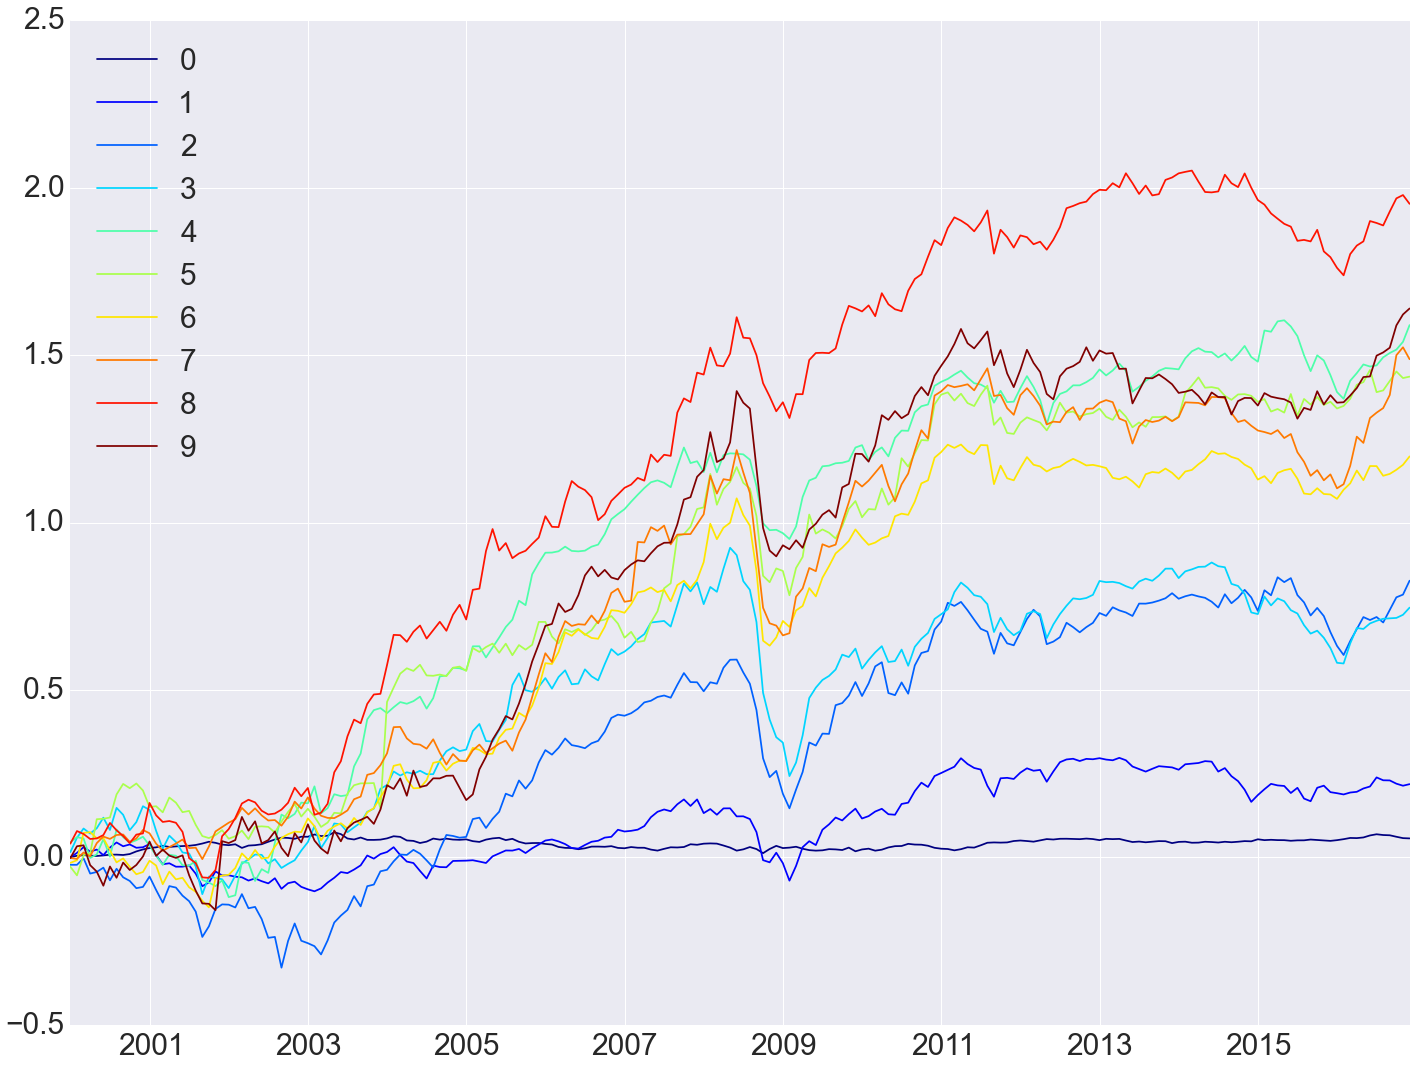

In [158]:
un_dec.dropna().cumsum().plot(colormap='jet')

In [163]:
un_dec.skew()

0   -0.264468
1   -0.447008
2   -0.475443
3   -1.032544
4   -0.002250
5    1.484012
6   -1.304429
7   -0.084724
8    0.198703
9   -0.182150
dtype: float64

In [183]:
res=pd.DataFrame()
res['Monthly Return']=un_dec.mean()*100
res['Standard Deviation']=un_dec.std()*math.sqrt(12)*100
res['Sharpe']=calc_Sharpe(un_dec)
res['Skewness']=un_dec.skew()
res['Excess Kurtosis']=un_dec.kurtosis()
res['Amihud']='XXX'
res['CAPM Alpha (in %)']='XXX'
res['CAPM Beta (in %)']='XXX'
res['AR(1)']='XXX'
res.T.round(2)

,0,1,2,3,4,5,6,7,8,9
Monthly Return,0.0278178,0.107247,0.405144,0.365692,0.779356,0.703911,0.587066,0.729447,0.956949,0.803656
Standard Deviation,1.50344,6.59892,12.3877,13.337,12.123,15.5964,12.0538,14.5587,14.0603,15.8932
Sharpe,0.222034,0.195026,0.392463,0.329034,0.771449,0.541596,0.584446,0.601246,0.816724,0.606792
Skewness,-0.264468,-0.447008,-0.475443,-1.03254,-0.00225049,1.48401,-1.30443,-0.0847239,0.198703,-0.18215
Excess Kurtosis,0.434086,2.01462,1.03573,4.45862,0.837399,12.3643,8.06539,3.68027,0.497336,3.45634
Amihud,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
CAPM Alpha (in %),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
CAPM Beta (in %),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
AR(1),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX


Now run regression of these time series on the overall market liquidity

Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)

In [184]:
mktliquid=amihud.median(axis=1).dropna()

1999-01-31    7.495855e-10
1999-02-28    8.638724e-10
1999-03-31    7.290625e-10
1999-04-30    7.272990e-10
1999-05-31    6.649110e-10
Freq: M, dtype: float64

In [199]:
ind=un_dec['9'].dropna().index
res=sm.OLS(un_dec['1'][ind],mktliquid[ind],hasconst=False).fit()

In [200]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                      1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.04408
Date:                Sun, 04 Jun 2017   Prob (F-statistic):              0.834
Time:                        16:51:37   Log-Likelihood:                 518.72
No. Observations:                 204   AIC:                            -1035.
Df Residuals:                     203   BIC:                            -1032.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.676e+06   7.98e+06      0.210      0.8